In [5]:
!pip install nb_black

In [6]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# QRM First Assignment

#### Discussion Box (Keep track of resolved issues here, will delete later)

**Questions so far:**
1. What is the difference between Close and Adj. Close? Which to use?
2. np.log is used for natural logarithm, right?
(Natural logarithm, element-wise. --copied from documentation page)

**Close price adjusted for splits.** 
<br>
''The closing price of a stock is the price of that stock at the close of the trading day.''


**Adjusted close price adjusted for both dividends and splits.**
<br>
''The adjusted closing price is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.''

So I think in the sense of these dataset, the close price is also a kind of adjusted price since it is adjusted for splits.<br>
I personally would think the adjusted close price (both div and splits) would be better since it's more accurate.

**Discussion:**
**1. Drop the 20 rows for N225 dataset?** <br>
AM: Correct and we need to synchronise with the rest of the data by only considering days where an observation is available for all risk factors <br>
**2. The DE_1YBOND attribute doesn't match with other 4, will the attribute affect the analysis? If not then we can keep them** <br>
AM: This is because the first 4 datasets are from Yahoo data and this one is from another source. It's not a problem as long as we can merge it by Date to the rest of the data.<br>
**3. There would defo some outliers in the data, we shoud decide how to deal with them.**<br>
AM: Good question, let's ask Svetlana and Sarah.

**09.04 AM:**
   1. I think that trying with 2 datasets should happen in a bit different way  ((done))
   2. Isolate the columns of adj. price for each asset and give them clear names to which asset they belong ((done))
   3. Perform a join with on the Date variable (I think the concat function is not doing the job here) ((done))

**11.04 Pan:** I fixed the above probelms.

##### I suggest to keep log of our Methodology and Questions and write email to Svetlana/Sarah next week to verify and ask - do you agree?

**Methodology**
1. Create lags for each individual asset and compute individual asset returns
2. Merge the individual asset datasets and compute portfolio returns and portfolio standard deviation

**Questions**
1. How to deal with unmatching data (i.e. there is obs. for a particular dataset for one asset but none for another asset?). Should we delete all observations for that date altogether? How do we deal with the gap in history? <br>
**Pan:** I took the intersection dates of all five assets. 
I am not sure if it is proper but this is the best we can do so far. <br>
We can ask them!!

2. How to deal with outliers? <br>
**Pan:** The data looks normal so outlier doesn't seem to be a big probelm, but maybe it would affect <br>
when adding the bond. Let's ask as well!

##### Question: My code above looks ugly as I am doing the operations for each dataset separately instead of using some kind of loop to iterate. Can we, please, set up a short call so you can teach me how to do the iteration? :D I will appreciate some CS help! 

**Pan:** Sure, I also took some time to make it into function. <br>
You can have a look and if you don't know some parts, we can have a call :D

## Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os

# from arch import arch_model
# from fnGARCH_2 import *

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

In [8]:
"""Import data"""
BTC = pd.read_csv("01_Data/BTCUSD.csv",)
DBC = pd.read_csv("01_Data/DBC.csv")
GSPC = pd.read_csv("01_Data/GSPC.csv")
N225 = pd.read_csv("01_Data/N225.csv")
DE_1YBOND = pd.read_csv("01_Data/DE_1YBOND.csv")
FX_YEN = pd.read_csv("01_Data/JPYUSD=X.csv")
FX_EUR = pd.read_csv("01_Data/EURUSD=X.csv")


"""Check format of the datasets"""
# print(BTC.shape)
# print(DBC.shape)
# print(DE_1YBOND.shape)
# print(GSPC.shape)
# print(N225.shape)
print(FX_YEN.shape)
print(FX_EUR.shape)

"""The attribute format of DE bond is different from others"""
# DE_1YBOND.head()
print(FX_YEN.head())

"""Check if there is null or empty input for any of the datasets."""
# N225.isnull().sum()
# BTC.isnull().sum()
# DBC.isnull().sum()
# GSPC.isnull().sum()
# DE_1YBOND.isnull().sum()
print(FX_YEN.isnull().sum())
print(FX_EUR.isnull().sum())

"""N225 has 20 missing values"""
# missing_N225 = N225[N225.isna().any(axis=1)]['Date']
# print(len(N225[N225.isna().any(axis=1)]))
# print(missing_N225)
print()

(2349, 7)
(2349, 7)
         Date      Open      High       Low     Close  Adj Close  Volume
0  2011-03-31  0.012027  0.012115  0.012019  0.012026   0.012026     0.0
1  2011-04-01  0.011996  0.012008  0.011808  0.011996   0.011996     0.0
2  2011-04-04  0.011874  0.011926  0.011865  0.011874   0.011874     0.0
3  2011-04-05  0.011887  0.011891  0.011808  0.011886   0.011886     0.0
4  2011-04-06  0.011744  0.011788  0.011699  0.011743   0.011743     0.0
Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64
Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64



<IPython.core.display.Javascript object>

**EDA shows 2 issues:**
<br>
1. The attribute format of the bond is different from the stocks
<br>
2. N225 contains 20 missing values, which need to be dropped

In [9]:
""" Change the date format of DE_1YBOND"""
from datetime import datetime

new_date = []
for i in DE_1YBOND["Date"]:
    new = datetime.strptime(i, "%b %d, %Y").strftime("%Y-%m-%d")
    new_date.append(new)

DE_1YBOND["Date"] = new_date

<IPython.core.display.Javascript object>

In [10]:
""" Drop the rows which contains missing value in N225"""
N225_drop = N225.dropna(axis=0)
N225_drop = N225_drop.reset_index(drop=True)
print(len(N225_drop))
# N225_drop.isnull().sum()

2205


<IPython.core.display.Javascript object>

In [11]:
""" Drop the rows which contains missing value in FX_YEN"""
FX_YEN_drop = FX_YEN.dropna(axis=0)
FX_YEN_drop = FX_YEN_drop.reset_index(drop=True)

""" Drop the rows which contains missing value in FX_EUR"""
FX_EUR_drop = FX_EUR.dropna(axis=0)
FX_EUR_drop = FX_EUR_drop.reset_index(drop=True)

print(len(FX_YEN_drop))
print(len(FX_EUR_drop))

2344
2344


<IPython.core.display.Javascript object>

## Data Processing

### 1. Merge data

In [12]:
s1 = set(GSPC["Date"])
s2 = set(DBC["Date"])
s3 = set(N225_drop["Date"])
s4 = set(BTC["Date"])
s5 = set(DE_1YBOND["Date"])
s6 = set(FX_YEN_drop["Date"])
s7 = set(FX_EUR_drop["Date"])

d = [
    x for x in s3 if x in s1 and x in s2 and x in s4 and x in s5 and x in s6 and x in s7
]

asset = [s1, s2, s3, s4, s5, s6, s7]

intersec = s3.intersection(s1, s2, s4, s5, s6, s7)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2112 trading days")

2112
2112
The dates exist in all five dataset: 2112 trading days


<IPython.core.display.Javascript object>

In [13]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [BTC, DBC, DE_1YBOND, GSPC, N225_drop, FX_YEN_drop, FX_EUR_drop]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

<IPython.core.display.Javascript object>

In [14]:
""" Assign the dataframe """

BTC_new = new[0]
DBC_new = new[1]
DE_1YBOND_new = new[2]
GSPC_new = new[3]
N225_new = new[4]
FX_YEN_new = new[5]
FX_EUR_new = new[6]

asset = [BTC_new, DBC_new, DE_1YBOND_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 6)
Date        0
Price       0
Open        0
High        0
Low         0
Change %    0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<IPython.core.display.Javascript object>

In [15]:
""" Process German Bonds data to match the format of the rest of the datasets """
"""Rename Columns"""
DE_1YBOND_new.rename(columns={"Price": "Adj Close"}, inplace=True)
"""Sort Data"""
DE_1YBOND_new = DE_1YBOND_new.sort_values(by=["Date"]).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [16]:
###SANDBOX


""" Create new dataframe containing only the same dates related information  """

# asset_price , asset_adj_price , return

asset = [DE_1YBOND_new, BTC_new, DBC_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]
asset_name = ["DE_1YBOND", "BTC", "DBC", "GSPC", "N225", "FX_YEN", "FX_EUR"]

for i in range(len(asset)):
    """Rename Price column"""
    asset[i].rename(columns={"Adj Close": "Price_" + asset_name[i]}, inplace=True)
    """Create lags for all assets"""
    asset[i]["Price_" + asset_name[i] + "_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    """Calculate individual asset returns"""
    # Bonds - simple difference between current and lagged value; Stocks - log return
    if i == 0:
        asset[i][asset_name[i] + "_return"] = (
            asset[i]["Price_" + asset_name[i]]
            - asset[i]["Price_" + asset_name[i] + "_lag"]
        )
    else:
        asset[i][asset_name[i] + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i]]
            / asset[i]["Price_" + asset_name[i] + "_lag"]
        )

    # Create stressed equity prices - that's some horrible coding in here
    asset[i]["Price_" + asset_name[i] + "_plus20"] = (
        asset[i]["Price_" + asset_name[i]] * 1.2
    )
    asset[i]["Price_" + asset_name[i] + "_plus40"] = (
        asset[i]["Price_" + asset_name[i]] * 1.4
    )
    asset[i]["Price_" + asset_name[i] + "_minus20"] = (
        asset[i]["Price_" + asset_name[i]] * 0.8
    )
    asset[i]["Price_" + asset_name[i] + "_minus40"] = (
        asset[i]["Price_" + asset_name[i]] * 0.6
    )

    # Create stressed returns
    asset[i]["Price_" + asset_name[i] + "_plus20_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_plus40_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_minus20_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_minus40_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)

    if i == 0:
        asset[i][asset_name[i] + "_plus20" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus20"]
            - asset[i]["Price_" + asset_name[i] + "_plus20_lag"]
        )
        asset[i][asset_name[i] + "_plus40" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus40"]
            - asset[i]["Price_" + asset_name[i] + "_plus40_lag"]
        )
        asset[i][asset_name[i] + "_minus20" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus20"]
            - asset[i]["Price_" + asset_name[i] + "_minus20_lag"]
        )
        asset[i][asset_name[i] + "_minus40" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus40"]
            - asset[i]["Price_" + asset_name[i] + "_minus40_lag"]
        )
    else:
        asset[i][asset_name[i] + "_plus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus20"]
            / asset[i]["Price_" + asset_name[i] + "_plus20_lag"]
        )
        asset[i][asset_name[i] + "_plus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus40"]
            / asset[i]["Price_" + asset_name[i] + "_plus40_lag"]
        )
        asset[i][asset_name[i] + "_minus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus20"]
            / asset[i]["Price_" + asset_name[i] + "_minus20_lag"]
        )
        asset[i][asset_name[i] + "_minus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus40"]
            / asset[i]["Price_" + asset_name[i] + "_minus40_lag"]
        )


print(DE_1YBOND_new)

            Date  Price_DE_1YBOND   Open   High    Low Change %  \
0     2011-03-31            1.209  1.209  1.209  1.209    2.28%   
1     2011-04-01            1.306  1.306  1.306  1.306    8.02%   
2     2011-04-04            1.292  1.292  1.292  1.292   -1.07%   
3     2011-04-05            1.299  1.299  1.299  1.299    0.54%   
4     2011-04-06            1.294  1.294  1.294  1.294   -0.38%   
...          ...              ...    ...    ...    ...      ...   
2107  2020-03-24           -0.604 -0.678 -0.600 -0.723  -12.21%   
2108  2020-03-25           -0.634 -0.615 -0.557 -0.674    4.97%   
2109  2020-03-26           -0.611 -0.645 -0.562 -0.679   -3.63%   
2110  2020-03-27           -0.702 -0.626 -0.600 -0.920   14.89%   
2111  2020-03-30           -0.689 -0.685 -0.658 -0.881   -1.85%   

      Price_DE_1YBOND_lag  DE_1YBOND_return  Price_DE_1YBOND_plus20  \
0                     NaN               NaN                  1.4508   
1                   1.209             0.097          

<IPython.core.display.Javascript object>

In [17]:
# Keep only relevant columns

result = []
for i in range(len(asset)):
    print(asset_name[i])
    if i == 0:
        asset[i] = asset[i][
            [
                "Date",
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus20" + "_return",
                asset_name[i] + "_plus40" + "_return",
                asset_name[i] + "_minus20" + "_return",
                asset_name[i] + "_minus40" + "_return",
            ]
        ]
        result.append(asset[i])
    else:
        asset[i] = asset[i][
            [
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus20" + "_return",
                asset_name[i] + "_plus40" + "_return",
                asset_name[i] + "_minus20" + "_return",
                asset_name[i] + "_minus40" + "_return",
            ]
        ]
        result.append(asset[i])

DE_1YBOND
BTC
DBC
GSPC
N225
FX_YEN
FX_EUR


<IPython.core.display.Javascript object>

In [18]:
# Check the shape
BTC_new = result[0]
DBC_new = result[1]
DE_1YBOND_new = result[2]
GSPC_new = result[3]
N225_new = result[4]
FX_YEN_new = result[5]
FX_EUR_new = result[6]


asset = [BTC_new,DBC_new, DE_1YBOND_new, GSPC_new,N225_new,FX_YEN_new,FX_EUR_new]


for i in asset:
    print(i.shape)


(2112, 8)
(2112, 7)
(2112, 7)
(2112, 7)
(2112, 7)
(2112, 7)
(2112, 7)


<IPython.core.display.Javascript object>

In [19]:
print(N225_new["N225_return"].head())
print(FX_YEN_new["FX_YEN_return"].head())

0         NaN
1   -0.004800
2    0.001081
3   -0.010690
4   -0.003248
Name: N225_return, dtype: float64
0         NaN
1   -0.002498
2   -0.010222
3    0.001010
4   -0.012104
Name: FX_YEN_return, dtype: float64


<IPython.core.display.Javascript object>

In [20]:
''' Add the Nikkei return and FX_YUAN together as one total N225 return'''

N225_new['N225_return_all']  = N225_new['N225_return']  + FX_YEN_new['FX_YEN_return'] 
N225_new = N225_new.drop(['N225_return'],axis=1)
N225_new.rename(columns={'N225_return_all':'N225_return'}, inplace=True)


C:\Users\Asus\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

In [21]:
N225_new

,Price_N225,Price_N225_lag,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return
0,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN
1,9708.389648,9755.099609,0.177522,0.331672,-0.227943,-0.515625,-0.007297
2,9718.889648,9708.389648,0.183403,0.337553,-0.222063,-0.509745,-0.009141
3,9615.549805,9718.889648,0.171632,0.325782,-0.233833,-0.521515,-0.009680
4,9584.370117,9615.549805,0.179074,0.333224,-0.226391,-0.514074,-0.015352
...,...,...,...,...,...,...,...
2107,18092.349609,16887.779297,0.251220,0.405371,-0.154245,-0.441927,0.065580
2108,19546.630859,18092.349609,0.259635,0.413786,-0.145830,-0.433512,0.074650
2109,18664.599609,19546.630859,0.136147,0.290298,-0.269318,-0.557000,-0.043954
2110,19389.429688,18664.599609,0.220421,0.374572,-0.185044,-0.472726,0.054158


<IPython.core.display.Javascript object>

In [22]:
"""And drop FX_YEN and FX_EUR from the list """
asset = [BTC_new, DBC_new, GSPC_new, N225_new, DE_1YBOND_new, FX_YEN_new, FX_EUR_new]

asset = asset[:-2]
print(asset)

[            Date  Price_DE_1YBOND  Price_DE_1YBOND_lag  DE_1YBOND_return  \
0     2011-03-31            1.209                  NaN               NaN   
1     2011-04-01            1.306                1.209             0.097   
2     2011-04-04            1.292                1.306            -0.014   
3     2011-04-05            1.299                1.292             0.007   
4     2011-04-06            1.294                1.299            -0.005   
...          ...              ...                  ...               ...   
2107  2020-03-24           -0.604               -0.688             0.084   
2108  2020-03-25           -0.634               -0.604            -0.030   
2109  2020-03-26           -0.611               -0.634             0.023   
2110  2020-03-27           -0.702               -0.611            -0.091   
2111  2020-03-30           -0.689               -0.702             0.013   

      DE_1YBOND_plus20_return  DE_1YBOND_plus40_return  \
0                         Na

<IPython.core.display.Javascript object>

In [23]:
# Merge
data = pd.concat(asset, axis=1)
data.head()

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus20_return,DE_1YBOND_plus40_return,DE_1YBOND_minus20_return,DE_1YBOND_minus40_return,Price_BTC,Price_BTC_lag,...,N225_minus20_return,N225_minus40_return,N225_return,Price_DBC,Price_DBC_lag,DBC_return,DBC_plus20_return,DBC_plus40_return,DBC_minus20_return,DBC_minus40_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.7846,NaN,...,NaN,NaN,NaN,29.643923,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.3582,0.6194,-0.1642,-0.4254,0.7741,0.7846,...,-0.227943,-0.515625,-0.007297,29.847960,29.643923,0.006859,0.189181,0.343332,-0.216284,-0.503966
2,2011-04-04,1.292,1.306,-0.014,0.2444,0.5028,-0.2724,-0.5308,0.6800,0.7741,...,-0.222063,-0.509745,-0.009141,30.120012,29.847960,0.009073,0.191395,0.345546,-0.214070,-0.501752
3,2011-04-05,1.299,1.292,0.007,0.2668,0.5266,-0.2528,-0.5126,0.7100,0.6800,...,-0.233833,-0.521515,-0.009680,30.149160,30.120012,0.000967,0.183289,0.337439,-0.222176,-0.509858
4,2011-04-06,1.294,1.299,-0.005,0.2538,0.5126,-0.2638,-0.5226,0.7400,0.7100,...,-0.226391,-0.514074,-0.015352,30.236607,30.149160,0.002896,0.185218,0.339369,-0.220247,-0.507929


<IPython.core.display.Javascript object>

### 2. Calculate portfolio returns (with and without Stress)

In [24]:
"""Assume equal weight (0.20) for the 5 assets and calculate portfolio returns - later to change it when we also add the bond"""

data["portfolio_return"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_plus20"] = (
    0.20 * data["BTC_plus20_return"]
    + 0.20 * data["DBC_plus20_return"]
    + 0.20 * data["GSPC_plus20_return"]
    + 0.20 * data["N225_plus20_return"]
    + 0.20 * data["DE_1YBOND_plus20_return"]
)
data["portfolio_return_plus40"] = (
    0.20 * data["BTC_plus40_return"]
    + 0.20 * data["DBC_plus40_return"]
    + 0.20 * data["GSPC_plus40_return"]
    + 0.20 * data["N225_plus40_return"]
    + 0.20 * data["DE_1YBOND_plus40_return"]
)
data["portfolio_return_minus20"] = (
    0.20 * data["BTC_minus20_return"]
    + 0.20 * data["DBC_minus20_return"]
    + 0.20 * data["GSPC_minus20_return"]
    + 0.20 * data["N225_minus20_return"]
    + 0.20 * data["DE_1YBOND_minus20_return"]
)
data["portfolio_return_minus40"] = (
    0.20 * data["BTC_minus40_return"]
    + 0.20 * data["DBC_minus40_return"]
    + 0.20 * data["GSPC_minus40_return"]
    + 0.20 * data["N225_minus40_return"]
    + 0.20 * data["DE_1YBOND_minus40_return"]
)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Average portfolio return')

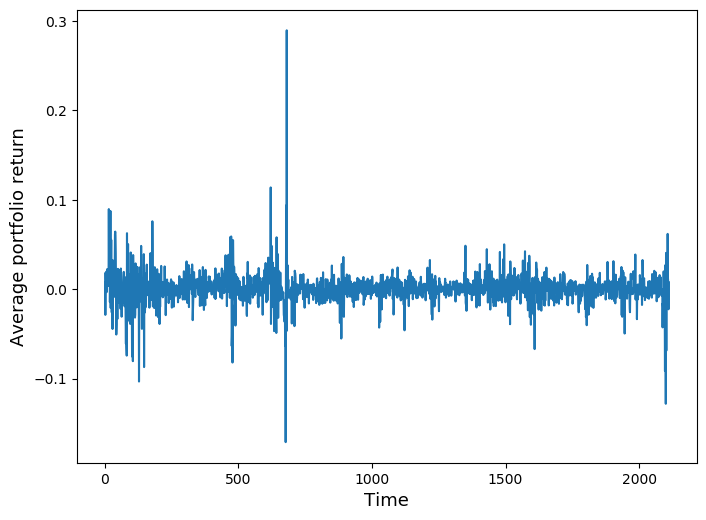

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(data["portfolio_return"])
plt.xlabel("Time", fontsize=13)
plt.ylabel("Average portfolio return", fontsize=13)

### 3. Plots

C:\Users\Asus\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


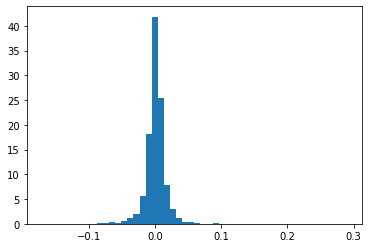

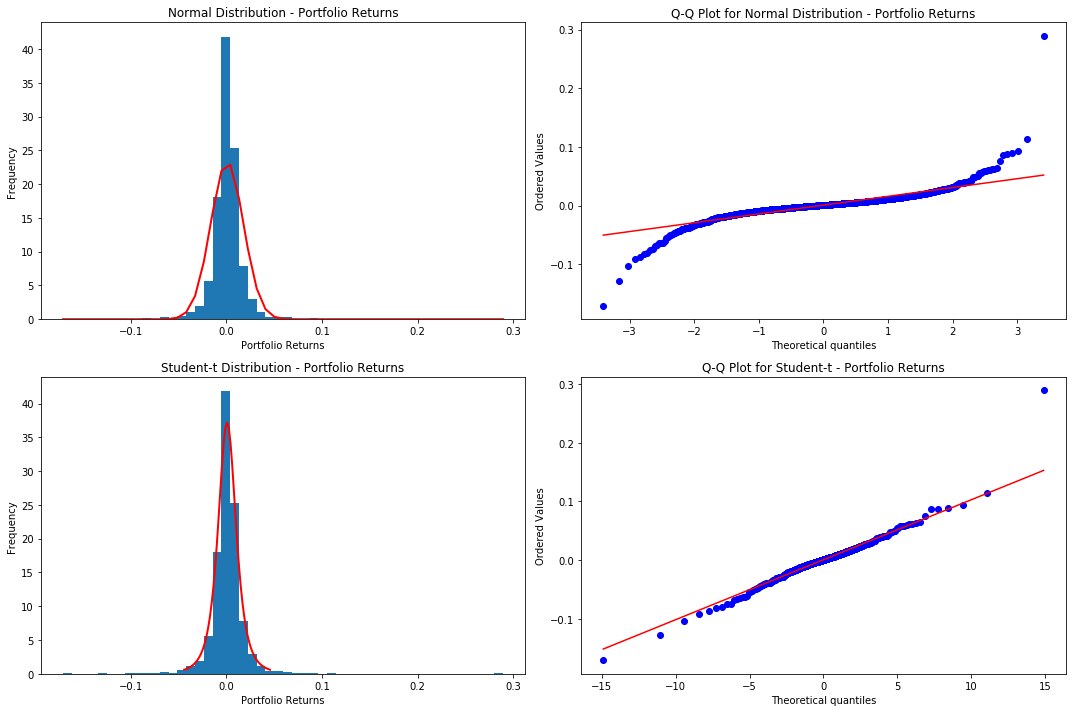

<IPython.core.display.Javascript object>

In [30]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

In [31]:
data

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus20_return,DE_1YBOND_plus40_return,DE_1YBOND_minus20_return,DE_1YBOND_minus40_return,Price_BTC,Price_BTC_lag,...,DBC_return,DBC_plus20_return,DBC_plus40_return,DBC_minus20_return,DBC_minus40_return,portfolio_return,portfolio_return_plus20,portfolio_return_plus40,portfolio_return_minus20,portfolio_return_minus40
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.784600,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.3582,0.6194,-0.1642,-0.4254,0.774100,0.784600,...,0.006859,0.189181,0.343332,-0.216284,-0.503966,0.017608,0.216205,0.391765,-0.212647,-0.495033
2,2011-04-04,1.292,1.306,-0.014,0.2444,0.5028,-0.2724,-0.5308,0.680000,0.774100,...,0.009073,0.191395,0.345546,-0.214070,-0.501752,-0.028666,0.170915,0.345916,-0.256817,-0.538642
3,2011-04-05,1.299,1.292,0.007,0.2668,0.5266,-0.2528,-0.5126,0.710000,0.680000,...,0.000967,0.183289,0.337439,-0.222176,-0.509858,0.008256,0.205871,0.381152,-0.222421,-0.504527
4,2011-04-06,1.294,1.299,-0.005,0.2538,0.5126,-0.2638,-0.5226,0.740000,0.710000,...,0.002896,0.185218,0.339369,-0.220247,-0.507929,0.005222,0.205260,0.380341,-0.222632,-0.504538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,2020-03-24,-0.604,-0.688,0.084,-0.0368,-0.1576,0.2048,0.3256,6734.804688,6416.314941,...,0.021449,0.203770,0.357921,-0.201695,-0.489377,0.061831,0.184192,0.283353,-0.091860,-0.297845
2108,2020-03-25,-0.634,-0.604,-0.030,-0.1568,-0.2836,0.0968,0.2236,6681.062500,6734.804688,...,0.016660,0.198981,0.353132,-0.206484,-0.494166,0.012953,0.133983,0.231944,-0.139669,-0.344454
2109,2020-03-26,-0.611,-0.634,0.023,-0.0992,-0.2214,0.1452,0.2674,6716.439941,6681.062500,...,-0.003484,0.178837,0.332988,-0.226628,-0.514310,0.008277,0.129251,0.228131,-0.146242,-0.351947
2110,2020-03-27,-0.702,-0.611,-0.091,-0.2314,-0.3718,0.0494,0.1898,6469.799316,6716.439941,...,-0.003497,0.178825,0.332976,-0.226640,-0.514322,-0.022404,0.092162,0.187402,-0.176050,-0.378116


<IPython.core.display.Javascript object>

Text(0.0, 1.0, 'e)')

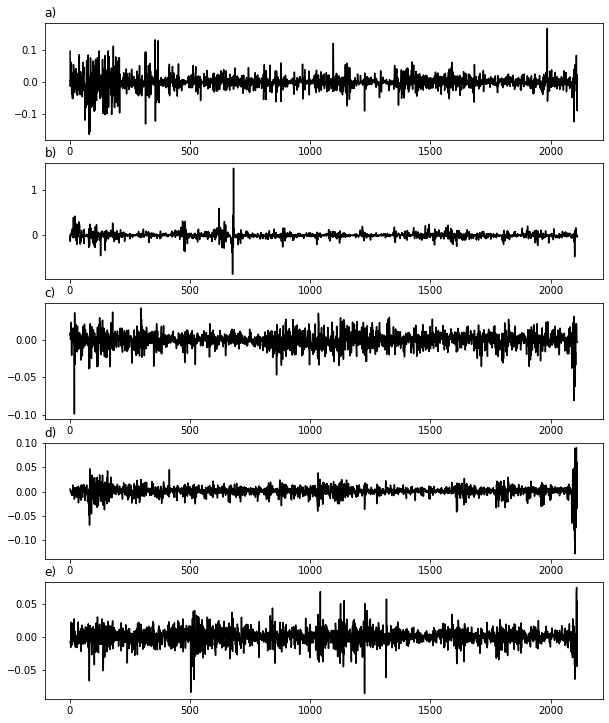

<IPython.core.display.Javascript object>

In [32]:
# plot of risk factor returns

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))
# DE_1YBOND
plt.subplot(6, 1, 1)
plt.plot(data["DE_1YBOND_return"][1:], "k")
plt.title("a)", loc="left")
# BTC_return
plt.subplot(6, 1, 2)
plt.plot(data["BTC_return"][1:], "k")
plt.title("b)", loc="left")
# DBC_return
plt.subplot(6, 1, 3)
plt.plot(data["DBC_return"][1:], "k")
plt.title("c)", loc="left")
# GSPC_return
plt.subplot(6, 1, 4)
plt.plot(data["GSPC_return"][1:], "k")
plt.title("d)", loc="left")
# N225_return
plt.subplot(6, 1, 5)
plt.plot(data["N225_return"][1:], "k")
plt.title("e)", loc="left")

## VaR and ES

### 1. Normal Distribution

In [33]:
def fnVaR_n(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    z = sc.stats.norm.ppf(alpha)
    VaR = (
        -mean + z * std
    )  # μ is negative of the return over one day, so should be negative sign
    VaR = -VaR

    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in percent is: ",
        round(VaR * 100, 2),
        "%",
        round(ES * 100, 2),
        "%",
    )

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in monetary terms is: ",
        round(VaR * initial_investment, 2),
        round(ES * initial_investment, 2),
    )

    return ()

<IPython.core.display.Javascript object>

In [34]:
# Set an initial investment level
initial_investment = 1000000
lookback = 3

df_prices = data[
    ["BTC_return", "DBC_return", "GSPC_return", "N225_return", "portfolio_return"]
]
weights = np.array([[0.25, 0.25, 0.25, 0.25]])


fnVaR_n(df_prices, weights, 0.025, lookback, 0.975, initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, 0.99, initial_investment)

( 97.5 %  VaR, ES) in percent is:  3.2 % 6.0 %
( 97.5 %  VaR, ES) in monetary terms is:  32008.38 59958.07
( 99.0 %  VaR, ES) in percent is:  3.79 % 6.29 %
( 99.0 %  VaR, ES) in monetary terms is:  37876.05 62902.43


()

<IPython.core.display.Javascript object>

**Pan:** Discussion points <br>
1. Ask about the dates
2. Ask about outliers
3. I set the monetary values as the percertage * the initial investment values (initials values of the portfolio?) <br>
Not sure if it's correct!!!!!!

### 2. Student t-distribution

### Check student t-assumption with QQ-plots

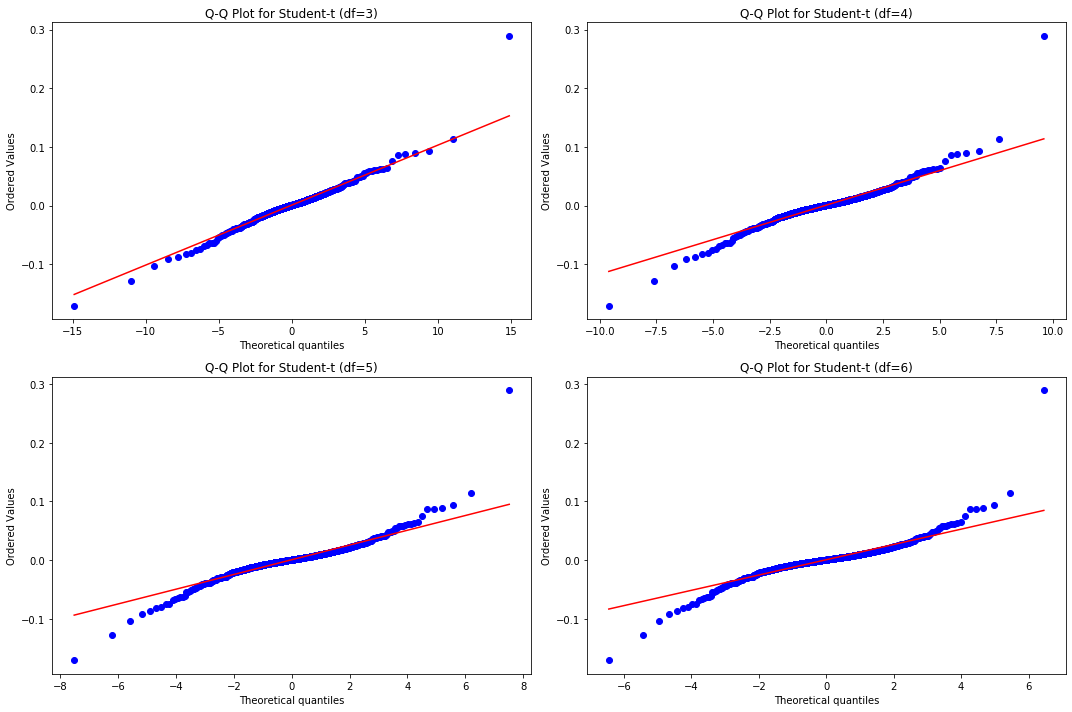

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

In [36]:
def fnVaR_t(dfData, weights, lookback, alpha, initial_investment, df, percent):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a t-distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    variance = (
        variance[0][0] * (df - 2) / df
    )  # account for variance of standard student-t

    # calculate quantile
    t = sc.stats.t.ppf(alpha, df)
    VaR = -mean + t * np.sqrt(variance)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output

    print(
        "DF=", df,
    )

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in percent is: ",
        round(VaR * 100, 2),
        "%",
        round(ES * 100, 2),
        "%",
    )

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in monetary terms is: ",
        round(VaR * initial_investment, 2),
        round(ES * initial_investment, 2),
    )

    return ()

<IPython.core.display.Javascript object>

In [37]:
fnVaR_t(df_prices, weights, lookback, 0.025, initial_investment, 3, 0.975)
fnVaR_t(df_prices, weights, lookback, 0.01, initial_investment, 3, 0.99)
fnVaR_t(df_prices, weights, lookback, 0.025, initial_investment, 4, 0.975)
fnVaR_t(df_prices, weights, lookback, 0.01, initial_investment, 4, 0.99)
fnVaR_t(df_prices, weights, lookback, 0.025, initial_investment, 5, 0.975)
fnVaR_t(df_prices, weights, lookback, 0.01, initial_investment, 5, 0.99)
fnVaR_t(df_prices, weights, lookback, 0.025, initial_investment, 6, 0.975)
fnVaR_t(df_prices, weights, lookback, 0.01, initial_investment, 6, 0.99)

DF= 3
( 97.5 %  VaR, ES) in percent is:  3.0 % 5.33 %
( 97.5 %  VaR, ES) in monetary terms is:  30045.29 53285.87
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.26 % 7.45 %
( 99.0 %  VaR, ES) in monetary terms is:  42604.15 74519.45
DF= 4
( 97.5 %  VaR, ES) in percent is:  3.21 % 6.0 %
( 97.5 %  VaR, ES) in monetary terms is:  32060.9 59958.07
DF= 4
( 99.0 %  VaR, ES) in percent is:  4.31 % 8.09 %
( 99.0 %  VaR, ES) in monetary terms is:  43051.22 80900.89
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.25 % 6.0 %
( 97.5 %  VaR, ES) in monetary terms is:  32508.05 59958.07
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.24 % 7.45 %
( 99.0 %  VaR, ES) in monetary terms is:  42362.12 74519.45
DF= 6
( 97.5 %  VaR, ES) in percent is:  3.26 % 6.0 %
( 97.5 %  VaR, ES) in monetary terms is:  32615.85 59958.07
DF= 6
( 99.0 %  VaR, ES) in percent is:  4.17 % 7.45 %
( 99.0 %  VaR, ES) in monetary terms is:  41713.74 74519.45


()

<IPython.core.display.Javascript object>

### 3. Historical simulation method

In [38]:
def fnVaR_hist(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with historical simulation
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    VaR = sc.percentile(DataTemp, alpha)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in percent is: ",
        round(VaR * 100, 2),
        "%",
        round(ES * 100, 2),
        "%",
    )

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in monetary terms is: ",
        round(VaR * initial_investment, 2),
        round(ES * initial_investment, 2),
    )

    return ()

<IPython.core.display.Javascript object>

In [39]:
fnVaR_hist(df_prices, weights, 0.025, lookback, 0.975, initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, 0.99, initial_investment)

( 97.5 %  VaR, ES) in percent is:  6.02 % 8.87 %
( 97.5 %  VaR, ES) in monetary terms is:  60209.74 88744.78
( 99.0 %  VaR, ES) in percent is:  9.19 % 12.8 %
( 99.0 %  VaR, ES) in monetary terms is:  91937.41 128013.01


()

<IPython.core.display.Javascript object>

**12.04 Pan**<br>
The histogram and QQ-plot are not functioning due to some undefined functions, maybe you can have a look :) <br> **AM**: fixed <br>
I still left out the bond one, you can add it into it!
I added the price return and exchange rate return together to form a new return which includes the FX exposure,
and I think it's correct. If it's wrong please let me know! <br> **13.04 AM:**:  <br> 
1/FX seems correct to me (I see you used the formula from the last lecture) <br>
2/About the bond - fixed some issues to integrate the data with the rest of the datasets. For now, I calculated the return as simple difference between current and lagged price. We can add to our list of questions to see if we should do it differently.. <br>
3/Added some plots <br>
4/Added calculations on stressed returns for the stocks, but with my very poor python skills it's ugly :(  <br>
<br>
**To-do:**
1. Investigate the sensitivity of your results to the length of the estimation period, i.e., estimate the variance-covariance matrix based on different past periods and compare the resulting VaR and ES estimates. Especially investigate the differences when you do and do not include stressed periods. - maybe we can compare January February and March this year (covid crisis) to the previous quarters?
2. GARCH(1,1)
3. EWMA
4. Backtest your VaR systems outlined above, by comparing the expected and the actual number of VaR violations per year and the average discrepancy between these two over all years. Also compare the expected shortfalls with average (per year) shortfalls. Plot the VaR violations against the time to investigate whether VaR violations occurred in clusters (indicating dependency between violations) or were evenly spread out in time.
5. Compute empirical 5- and 10-days VaRs using historical simulation method (use non-overlapping data!), compare them to the VaRs obtained from the one-day VaR with the square root of time rule and assess the adequacy of this rule applied to your portfolio.
6. Complement your VaR system with stress testing, where you let extreme scenarios happen to your main risk factors. Use the following guidelines to generate extreme scenarios (use separate scenarios for risk factors, so not combinations of these):
    - Equity index values or stock prices changing by +/- 20% and +/- 40% of the current values (portfolio returns done)
    - Currencies moving by +/- 10% for major currencies and +/- 20% for other currencies.
    - Commodity prices changing by +/- 20% and +/-40% of the current values.
    - Interest rates shifting by +/- 2% and +/- 3%.

### 4. EWMA

In [43]:
def fnVaR_EWMA(dfData, weights, ewma_con, alpha, lookback, percent):
    """
    purpose:
        calculates VaR and ES with EWMA method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        ewma_con, smoothing constant
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    # express years in days
    years = lookback

    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)

    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances = np.zeros((len(DataTemp), 4))
    # initialize variance
    for i in range(4):
        vVariances[0, i] = np.var(DataTemp.iloc[:, i])
    # calculate EWMA
    for i in range(1, len(DataTemp)):
        for j in range(4):
            sigma2hat = (
                ewma_con * vVariances[i - 1, j]
                + (1 - ewma_con) * DataTemp.iloc[i - 1, j] ** 2
            )
            vVariances[i, j] = sigma2hat
    # fill diagonal elements of covariance matrix with GARCH estimates
    np.fill_diagonal(cov, vVariances[-1, :])

    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate quantile
    VaR = sc.percentile(DataTemp, alpha)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in percent is: ",
        round(VaR * 100, 2),
        "%",
        round(ES * 100, 2),
        "%",
    )

    print(
        "(",
        percent * 100,
        "%",
        " VaR, ES) in monetary terms is: ",
        round(VaR * initial_investment, 2),
        round(ES * initial_investment, 2),
    )

    return ()

<IPython.core.display.Javascript object>

In [45]:
fnVaR_EWMA(df_prices, weights, 0.9, 0.025, lookback, 0.975)
fnVaR_EWMA(df_prices, weights, 0.9, 0.01, lookback, 0.99)

( 97.5 %  VaR, ES) in percent is:  6.02 % 8.87 %
( 97.5 %  VaR, ES) in monetary terms is:  60209.74 88744.78
( 99.0 %  VaR, ES) in percent is:  9.19 % 12.8 %
( 99.0 %  VaR, ES) in monetary terms is:  91937.41 128013.01


(0.09193740724518974, 0.12801301241783097)

<IPython.core.display.Javascript object>

### 5. GARCH